# 准备工作
下载数据，安装需要的库
算法参考了github的H-Freax同学，感谢。

In [ ]:
!git clone https://gitee.com/jianywu/ML_chapter7_dataset.git
!ls ML_chapter7_dataset  

Cloning into 'ML_chapter7_dataset'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
final  lgb_baseline_version1_chapter7.ipynb  README.md


In [ ]:
pip install category_encoders

     |████████████████████████████████| 81kB 5.3MB/s 


In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
import category_encoders as ce #CatBoostEncoder的相关包

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 加载数据

In [ ]:
seed = 42

kf = KFold(n_splits=5, random_state=seed, shuffle=True)
df_train = pd.read_csv('ML_chapter7_dataset/final/train_final.csv')
df_test = pd.read_csv('ML_chapter7_dataset/final/test_final.csv')

# 加衍生变量

### 给continuous_loan_amnt取对数

In [ ]:
train_ZQ = df_train.copy()
test_ZQ = df_test.copy()

trainbins=np.floor(np.log10(train_ZQ['continuous_loan_amnt']))   #取对数之后再向下取整
testbins=np.floor(np.log10(test_ZQ['continuous_loan_amnt']))

train_ZQ['continuous_loan_amnt_km']=trainbins
test_ZQ['continuous_loan_amnt_km']=testbins


#### data preprocessing

In [ ]:
X_train = train_ZQ.drop(columns=['loan_status']).values
Y_train = train_ZQ['loan_status'].values.astype(int)
X_test = test_ZQ.drop(columns=['loan_status']).values
Y_test = test_ZQ['loan_status'].values.astype(int)

# split data for five fold

five_fold_data = []

for train_index, eval_index in kf.split(X_train):
    x_train, x_eval = X_train[train_index], X_train[eval_index]
    y_train, y_eval = Y_train[train_index], Y_train[eval_index]
    
    five_fold_data.append([(x_train, y_train), (x_eval, y_eval)])

#### Algorithm

In [ ]:
def get_model(param):
    model_list = []
    for idx, [(x_train, y_train), (x_eval, y_eval)] in enumerate(five_fold_data):
        print('{}-th model is training:'.format(idx))
        train_data = lgb.Dataset(x_train, label=y_train)
        validation_data = lgb.Dataset(x_eval, label=y_eval)
        bst = lgb.train(param, train_data, valid_sets=[validation_data])
        model_list.append(bst)
    return model_list

#### Train

三种模型

---
*   base
*   fine tuning
*   fine tuning final(结果最好的最终版本)

1.   跑得快：num_thread.
2.   提高准确率: num_leaves, max_depth.
3.   降低过拟合: max_bin, feature_fraction, bagging_fraction.



In [ ]:
param_base = {'num_leaves': 31, 'objective': 'binary', 'metric': 'binary', 'num_round':1000}

param_fine_tuning = {'num_thread': 8,'num_leaves': 128, 'metric': 'binary', 'objective': 'binary', 'num_round': 1000, 
                     'learning_rate': 3e-3, 'feature_fraction': 0.6, 'bagging_fraction': 0.8}


param_fine_tuningfinal={'num_thread': 8,'num_leaves': 128, 'metric': 'binary', 'objective': 'binary', 'num_round': 900, 
                     'learning_rate': 7e-3, 'feature_fraction': 0.8, 'bagging_fraction': 0.6,'max_depth':20,'min_sum_hessian_in_leaf':100}

In [ ]:
# base param train
param_base_model = get_model(param_base)

# param fine tuning
param_fine_tuning_model = get_model(param_fine_tuning)

param_fine_tuningfinal_model = get_model(param_fine_tuningfinal)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Streaming output truncated to the last 5000 lines.
[506]	valid_0's binary_logloss: 0.238235
[507]	valid_0's binary_logloss: 0.238059
[508]	valid_0's binary_logloss: 0.237889
[509]	valid_0's binary_logloss: 0.237718
[510]	valid_0's binary_logloss: 0.237552
[511]	valid_0's binary_logloss: 0.237383
[512]	valid_0's binary_logloss: 0.237213
[513]	valid_0's binary_logloss: 0.237044
[514]	valid_0's binary_logloss: 0.237011
[515]	valid_0's binary_logloss: 0.236982
[516]	valid_0's binary_logloss: 0.236814
[517]	valid_0's binary_logloss: 0.236646
[518]	valid_0's binary_logloss: 0.236484
[519]	valid_0's binary_logloss: 0.236315
[520]	valid_0's binary_logloss: 0.236147
[521]	valid_0's binary_logloss: 0.235984
[522]	valid_0's binary_logloss: 0.235821
[523]	valid_0's binary_logloss: 0.235792
[524]	valid_0's binary_logloss: 0.235629
[525]	valid_0's binary_logloss: 0.235469
[526]	valid_0's binary_logloss: 0.235442
[527]	valid_0's binary_logloss: 0.235281
[528]	valid_0's binary_logloss: 0.235126
[529]	

#### Test(0.91842)

In [ ]:
def test_model(model_list):
    data = X_test
    five_fold_pred = np.zeros((5, len(X_test)))
    for i, bst in enumerate(model_list):
        ypred = bst.predict(data, num_iteration=bst.best_iteration)
        five_fold_pred[i] = ypred
    ypred_mean = (five_fold_pred.mean(axis=-2)>0.5).astype(int)
    return accuracy_score(ypred_mean, Y_test)

In [ ]:
base_score = test_model(param_base_model)
fine_tuning_score = test_model(param_fine_tuning_model)
fine_tuningfinal_score=test_model(param_fine_tuningfinal_model)

print('base: {}, fine tuning: {} , fine tuning final: {}'.format(base_score, fine_tuning_score, fine_tuningfinal_score))

base: 0.91586, fine tuning: 0.91764 , fine tuning final: 0.91842


## 业务分析得出衍生变量

---


*   installment_feat = continuous_installment / (continuous_anual_inc + 1) / 12
其中+1是为了避免除0.




In [ ]:
train_YW = df_train.copy()
test_YW = df_test.copy()

train_YW['installment_feat']=train_YW['continuous_installment'] / ((train_YW['continuous_annual_inc']+1) / 12)
test_YW['installment_feat']=test_YW['continuous_installment'] / ((test_YW['continuous_annual_inc']+1) / 12)

### data preprocessing

In [ ]:
X_train = train_YW.drop(columns=['loan_status']).values
Y_train = train_YW['loan_status'].values.astype(int)
X_test = test_YW.drop(columns=['loan_status']).values
Y_test = test_YW['loan_status'].values.astype(int)

# split data for five fold

five_fold_data = []

for train_index, eval_index in kf.split(X_train):
    x_train, x_eval = X_train[train_index], X_train[eval_index]
    y_train, y_eval = Y_train[train_index], Y_train[eval_index]
    
    five_fold_data.append([(x_train, y_train), (x_eval, y_eval)])

### Algorithm

In [ ]:
def get_model(param):
    model_list = []
    for idx, [(x_train, y_train), (x_eval, y_eval)] in enumerate(five_fold_data):
        print('{}-th model is training:'.format(idx))
        train_data = lgb.Dataset(x_train, label=y_train)
        validation_data = lgb.Dataset(x_eval, label=y_eval)
        bst = lgb.train(param, train_data, valid_sets=[validation_data])
        model_list.append(bst)
    return model_list

### Train

In [ ]:
param_base = {'num_leaves': 31, 'objective': 'binary', 'metric': 'binary', 'num_round':1000}

param_fine_tuning = {'num_thread': 8,'num_leaves': 128, 'metric': 'binary', 'objective': 'binary', 'num_round': 1000, 
                     'learning_rate': 3e-3, 'feature_fraction': 0.6, 'bagging_fraction': 0.8}

param_fine_tuningfinal={'num_thread': 8,'num_leaves': 128, 'metric': 'binary', 'objective': 'binary', 'num_round': 900, 
                     'learning_rate': 7e-3, 'feature_fraction': 0.8, 'bagging_fraction': 0.6,'max_depth':20,'min_sum_hessian_in_leaf':100}

In [ ]:
# base param train
param_base_model = get_model(param_base)

# param fine tuning
param_fine_tuning_model = get_model(param_fine_tuning)

param_fine_tuningfinal_model = get_model(param_fine_tuningfinal)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Streaming output truncated to the last 5000 lines.
[506]	valid_0's binary_logloss: 0.238186
[507]	valid_0's binary_logloss: 0.238008
[508]	valid_0's binary_logloss: 0.237837
[509]	valid_0's binary_logloss: 0.237664
[510]	valid_0's binary_logloss: 0.237499
[511]	valid_0's binary_logloss: 0.237334
[512]	valid_0's binary_logloss: 0.237165
[513]	valid_0's binary_logloss: 0.237
[514]	valid_0's binary_logloss: 0.236967
[515]	valid_0's binary_logloss: 0.236936
[516]	valid_0's binary_logloss: 0.236765
[517]	valid_0's binary_logloss: 0.236601
[518]	valid_0's binary_logloss: 0.236439
[519]	valid_0's binary_logloss: 0.236274
[520]	valid_0's binary_logloss: 0.236112
[521]	valid_0's binary_logloss: 0.235953
[522]	valid_0's binary_logloss: 0.23579
[523]	valid_0's binary_logloss: 0.235762
[524]	valid_0's binary_logloss: 0.235598
[525]	valid_0's binary_logloss: 0.235437
[526]	valid_0's binary_logloss: 0.235411
[527]	valid_0's binary_logloss: 0.235247
[528]	valid_0's binary_logloss: 0.235087
[529]	vali

### Test(0.91844)

In [ ]:
def test_model(model_list):
    data = X_test
    five_fold_pred = np.zeros((5, len(X_test)))
    for i, bst in enumerate(model_list):
        ypred = bst.predict(data, num_iteration=bst.best_iteration)
        five_fold_pred[i] = ypred
    ypred_mean = (five_fold_pred.mean(axis=-2)>0.5).astype(int)
    return accuracy_score(ypred_mean, Y_test)

In [ ]:
base_score = test_model(param_base_model)
fine_tuning_score = test_model(param_fine_tuning_model)
fine_tuningfinal_score=test_model(param_fine_tuningfinal_model)

print('base: {}, fine tuning: {} , fine tuning final: {}'.format(base_score, fine_tuning_score, fine_tuningfinal_score))

base: 0.9162, fine tuning: 0.91758 , fine tuning final: 0.91844


# 机器学习方式

##数据准备

In [ ]:
train_ML = df_train.copy()
test_ML = df_test.copy()

In [ ]:
train_ML.fillna(0,inplace=True)
test_ML.fillna(0,inplace=True)

X_train = train_ML.drop(columns=['loan_status']).values
Y_train = train_ML['loan_status'].values.astype(int)
X_test = test_ML.drop(columns=['loan_status']).values
Y_test = test_ML['loan_status'].values.astype(int)

In [ ]:
X_train

array([[5.50e+04, 0.00e+00, 0.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [6.50e+04, 0.00e+00, 1.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [6.30e+04, 7.10e+04, 0.00e+00, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       ...,
       [5.10e+04, 0.00e+00, 0.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [4.55e+05, 0.00e+00, 0.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [5.80e+04, 0.00e+00, 0.00e+00, ..., 0.00e+00, 1.00e+00, 0.00e+00]])

## 机器学习方法

### 随机森林(0.9164)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators = 100,random_state = 20)
rnd_clf.fit(X_train,Y_train)
rnd_clf.score(X_test,Y_test)

0.9164

### SGDClassifier 随机梯度下降(0.8639)

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=20) #random_state用于复现
sgd_clf.fit(X_train,Y_train)
sgd_clf.score(X_test,Y_test)

0.8639

### 逻辑回归(0.91108)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state = 20)
lr_clf.fit(X_train,Y_train)
lr_clf.score(X_test,Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.91108

### GBDT(0.91772)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gdbt_clf = GradientBoostingClassifier(random_state = 20)
gdbt_clf.fit(X_train,Y_train)
gdbt_clf.score(X_test,Y_test)

0.91772

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(gdbt_clf,X_train,Y_train,cv=3)

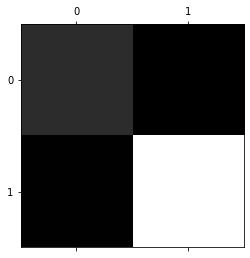

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mx=confusion_matrix(Y_train,y_train_pred)
conf_mx

plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [ ]:
conf_mx

array([[ 8271,  1941],
       [ 2098, 37690]])

###SVM 支持向量机分类器(0.80448)

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,Y_train)
svm_clf.score(X_test,Y_test)

0.80448

### Ada分类器(0.91604)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train,Y_train)
ada_clf.score(X_test,Y_test)

0.91604

### lightgbm(0.91768)

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train,Y_train)
lgbm_clf.score(X_test,Y_test)

0.91768

### XGB分类器(0.91712)

In [ ]:
from xgboost import XGBClassifier #XGB分类器
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train,Y_train)
xgb_clf.score(X_test,Y_test)

0.91712

###贝叶斯分类器(0.90478)

In [ ]:
from sklearn.naive_bayes import GaussianNB
nby_clf = GaussianNB()
nby_clf.fit(X_train,Y_train)
nby_clf.score(X_test,Y_test)

0.90478

###K近邻分类器(0.84852)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc_clf = KNeighborsClassifier()
knc_clf.fit(X_train,Y_train)
knc_clf.score(X_test,Y_test)

0.84852

## 集成

### 投票融合法(0.91814)

In [ ]:
from sklearn.ensemble import VotingClassifier      #投票分类器


In [ ]:

voting_clf = VotingClassifier(estimators=[('rf',rnd_clf ),('gdbt',gdbt_clf ),('ada',ada_clf ),('lgbm',lgbm_clf ),('xgb',xgb_clf )],#estimators:子分类器
                              voting='hard') #参数voting代表你的投票方式，hard,soft
                              



In [ ]:
# 训练模型，输出各模型准确率
from sklearn.metrics import accuracy_score
for clf in (lr_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,Y_train)
    y_pre = clf.predict(X_test)
    print(clf.__class__,accuracy_score(y_pre,Y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<class 'sklearn.linear_model._logistic.LogisticRegression'> 0.91108
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.9164
<class 'sklearn.svm._classes.SVC'> 0.80448
<class 'sklearn.ensemble._voting.VotingClassifier'> 0.91814




```
<class 'sklearn.linear_model._logistic.LogisticRegression'> 0.91108
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.9164
<class 'sklearn.svm._classes.SVC'> 0.80448
<class 'sklearn.ensemble._voting.VotingClassifier'> 0.91814
```



如果所有的分类器都能够估计类概率(即sklearn中它们都有一个predict_proba()方法)，那么可以求出类别的概率平均值，投票分类器将具有最高概率的类作为自己的预测。这称为软投票。在代码中只需要两处做更改，在支持向量机中，需要将参数probablity设置为True，使支持向量机具备预测类概率的功能。投票分类器中需要把voting设置为soft

In [ ]:
#soft voting
svm_clf1 = SVC(probability=True)
voting_clf = VotingClassifier(estimators=[('lf',lr_clf),('svc',svm_clf1),('rf',rnd_clf)],
                             voting='soft')
for clf in (lr_clf, rnd_clf, svm_clf1, voting_clf):
    clf.fit(X_train,Y_train)
    y_pre = clf.predict(X_test)
    print(clf.__class__,accuracy_score(y_pre,Y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<class 'sklearn.linear_model._logistic.LogisticRegression'> 0.91108
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.9164
<class 'sklearn.svm._classes.SVC'> 0.80448


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<class 'sklearn.ensemble._voting.VotingClassifier'> 0.91664




```
<class 'sklearn.linear_model._logistic.LogisticRegression'> 0.91108
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.9164
<class 'sklearn.svm._classes.SVC'> 0.80448
<class 'sklearn.ensemble._voting.VotingClassifier'> 0.91664
```

效果下降了



### stacking堆叠(0.91798)

堆叠是一种集成学习技术，它使用来自多个模型（例如决策树，knn或svm）的预测来构建新模型。该模型用于对测试集进行预测。以下是简单堆叠集成的逐步说明：

1. 把训练集分为10个组。

2. 基础模型（例如决策树）用训练集中的9个组进行训练，用第10个组进行预测。

3. 然后将基础模型（例如决策树）拟合到整个训练数据集上。


4. 使用此模型，在测试集上进行预测。


5. 对另一个基本模型（比如knn）重复步骤2到4，产生对训练集和测试集的另一组预测。


6. 训练集的预测被用作构建新模型的特征。


7. 该模型用于对测试预测集进行最终预测。

In [ ]:
from sklearn.model_selection import StratifiedKFold
def Stacking(model,train,y,test,n_fold):
  folds=StratifiedKFold(n_splits=n_fold,random_state=1)
  test_pred=np.empty((test.shape[0],1),float)
  train_pred=np.empty((0,1),float)
  for train_indices,val_indices in folds.split(train,y.values):
    
    x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
    y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

    model.fit(X=x_train,y=y_train)
    train_pred=np.append(train_pred,model.predict(x_val))
    test_pred=np.column_stack((test_pred,model.predict(test)))
  test_pred_a=np.mean(test_pred,axis=1) #按行计算均值
  return test_pred_a.reshape(-1,1),train_pred

采用gdbt和lgbm堆第0层

In [ ]:
x_train=train_ML.drop(columns=['loan_status'])
x_test=test_ML.drop(columns=['loan_status'])
y_train=train_ML['loan_status']

test_pred1 ,train_pred1=Stacking(model=gdbt_clf,n_fold=10, train=x_train,test=x_test,y=y_train)
print(test_pred1.size)
train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

test_pred2 ,train_pred2=Stacking(model=lgbm_clf,n_fold=10,train=x_train,test=x_test,y=y_train)
print(test_pred2.size)
train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


50000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


50000


采用随机森林堆第一层

In [ ]:
dff = pd.concat([train_pred1, train_pred2], axis=1)
dff_test = pd.concat([test_pred1, test_pred2], axis=1)

rnd_clf.fit(dff,y_train)
rnd_clf.score(dff_test, Y_test)

0.91798

### stacking混合(0.91668)

混合遵循与堆叠相同的方法，但仅使用来自训练集的保留/（验证）集来进行预测。换句话说，与堆叠不同，预测仅在保留集上进行。保留集和它的预测用于构建模型，用测试集对这个模型进行测试。以下是混合过程的详细说明：

1. 原始的训练集分为训练集和验证集。

2. 把模型拟合到训练集上。

3. 预测在验证集和测试集上进行。

4. 验证集及其预测用作构建新模型的特征。

5. 该模型用于对测试集和元特征（meta-features）进行最终预测。

同样的顺序

先采用gdbt和lgbm
再采用随机森林

In [ ]:
x_train=train_ML.drop(columns=['loan_status'])
x_test=test_ML.drop(columns=['loan_status'])
y_train=train_ML['loan_status']

val_pred1 = gdbt_clf.predict(x_train)
test_pred1 = gdbt_clf.predict(x_test)
val_pred1 = pd.DataFrame(val_pred1)
test_pred1 = pd.DataFrame(test_pred1)


val_pred2 = lgbm_clf.predict(x_train)
test_pred2 = lgbm_clf.predict(x_test)
val_pred2 = pd.DataFrame(val_pred2)
test_pred2 = pd.DataFrame(test_pred2)

df2_val = pd.concat([x_train,val_pred1,val_pred2],axis = 1)
df2_test = pd.concat([x_test,test_pred1,test_pred2],axis = 1)

rnd_clf.fit(df2_val,y_train)
rnd_clf.score(df2_test,Y_test)

0.91668

#深度学习网络


##DNN(0.9034)

###数据准备

In [ ]:
train_DL = df_train.copy()
test_DL = df_test.copy()
train_DL.fillna(0,inplace=True)
test_DL.fillna(0,inplace=True)

X_train = train_DL.drop(columns=['loan_status']).values
Y_train = train_DL['loan_status'].values.astype(int)
X_test = test_DL.drop(columns=['loan_status']).values
Y_test = test_DL['loan_status'].values.astype(int)

from tensorflow.keras.utils import to_categorical
Y_test=to_categorical(Y_test,2).astype(int)
Y_train=to_categorical(Y_train,2).astype(int)

###搭建网络

In [ ]:

import keras as K
from keras.layers.core import Dropout
init = K.initializers.glorot_uniform(seed=1)
model = K.models.Sequential()
model.add(K.layers.Dense(units=146, input_dim=145, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=147, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='softmax'))
model.compile(loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:

b_size = 128
max_epochs = 100
print("Starting training ")

h = model.fit(X_train, Y_train, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1)
print("Training finished \n")

Starting training 
Epoch 1/100
391/391 [==============================] - 3s 2ms/step - loss: 679.4492 - accuracy: 0.6736
Epoch 2/100
391/391 [==============================] - 1s 2ms/step - loss: 152.3317 - accuracy: 0.6935
Epoch 3/100
391/391 [==============================] - 1s 2ms/step - loss: 43.7786 - accuracy: 0.6880
Epoch 4/100
391/391 [==============================] - 1s 2ms/step - loss: 11.9479 - accuracy: 0.6836
Epoch 5/100
391/391 [==============================] - 1s 2ms/step - loss: 2.6031 - accuracy: 0.7051
Epoch 6/100
391/391 [==============================] - 1s 2ms/step - loss: 0.9054 - accuracy: 0.7549
Epoch 7/100
391/391 [==============================] - 1s 2ms/step - loss: 0.6135 - accuracy: 0.7804
Epoch 8/100
391/391 [==============================] - 1s 2ms/step - loss: 0.5161 - accuracy: 0.8007
Epoch 9/100
391/391 [==============================] - 1s 2ms/step - loss: 0.6039 - accuracy: 0.7997
Epoch 10/100
391/391 [==============================] - 1s 2ms/ste

### 测试结果

In [ ]:
eval = model.evaluate(X_test, Y_test, verbose=0)
print("Evaluation on test data: loss = %0.6f accuracy = %0.2f%% \n" \
          % (eval[0], eval[1] * 100) )

Evaluation on test data: loss = 0.228634 accuracy = 90.34% 



##深度学习网络DNN+trick（adam）(0.9120)


###数据准备

In [ ]:
train_DL = df_train.copy()
test_DL = df_test.copy()

In [ ]:
train_DL.fillna(0,inplace=True)
test_DL.fillna(0,inplace=True)

X_train = train_DL.drop(columns=['loan_status']).values
Y_train = train_DL['loan_status'].values.astype(int)
X_test = test_DL.drop(columns=['loan_status']).values
Y_test = test_DL['loan_status'].values.astype(int)

from tensorflow.keras.utils import to_categorical
Y_test=to_categorical(Y_test,2).astype(int)
Y_train=to_categorical(Y_train,2).astype(int)

###搭建网络

In [ ]:

import keras as K
from keras.layers.core import Dropout
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()#trick为添加了adam
model = K.models.Sequential()
model.add(K.layers.Dense(units=146, input_dim=145, kernel_initializer=init, activation='relu'))
# model.add(Dropout(0.1))#采用dropout效果并不好
model.add(K.layers.Dense(units=147, kernel_initializer=init, activation='relu'))
# model.add(Dropout(0.9))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])

In [ ]:

b_size = 128
max_epochs = 100
print("Starting training ")

h = model.fit(X_train, Y_train, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1)
print("Training finished \n")

Starting training 
Epoch 1/100
391/391 [==============================] - 1s 2ms/step - loss: 182.1639 - accuracy: 0.6965
Epoch 2/100
391/391 [==============================] - 1s 2ms/step - loss: 83.9741 - accuracy: 0.7180
Epoch 3/100
391/391 [==============================] - 1s 2ms/step - loss: 108.8326 - accuracy: 0.7316
Epoch 4/100
391/391 [==============================] - 1s 2ms/step - loss: 43.0062 - accuracy: 0.7542
Epoch 5/100
391/391 [==============================] - 1s 2ms/step - loss: 39.5238 - accuracy: 0.7644
Epoch 6/100
391/391 [==============================] - 1s 2ms/step - loss: 40.4723 - accuracy: 0.7681
Epoch 7/100
391/391 [==============================] - 1s 2ms/step - loss: 14.9108 - accuracy: 0.8280
Epoch 8/100
391/391 [==============================] - 1s 2ms/step - loss: 19.9646 - accuracy: 0.8051
Epoch 9/100
391/391 [==============================] - 1s 2ms/step - loss: 20.8583 - accuracy: 0.7967
Epoch 10/100
391/391 [==============================] - 1s 2m

### 测试结果

In [ ]:
eval = model.evaluate(X_test, Y_test, verbose=0)
print("Evaluation on test data: loss = %0.6f accuracy = %0.2f%% \n" \
          % (eval[0], eval[1] * 100) )

Evaluation on test data: loss = 0.215142 accuracy = 91.20% 



##深度学习网络DNN+trick（SGD）(0.9104)


###数据准备

In [ ]:
train_DL = df_train.copy()
test_DL = df_test.copy()

In [ ]:
train_DL.fillna(0,inplace=True)
test_DL.fillna(0,inplace=True)

X_train = train_DL.drop(columns=['loan_status']).values
Y_train = train_DL['loan_status'].values.astype(int)
X_test = test_DL.drop(columns=['loan_status']).values
Y_test = test_DL['loan_status'].values.astype(int)

from tensorflow.keras.utils import to_categorical
Y_test=to_categorical(Y_test,2).astype(int)
Y_train=to_categorical(Y_train,2).astype(int)

###搭建网络

In [ ]:
import keras as K
from keras.layers.core import Dropout
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)#trick为添加了RMSprop
model = K.models.Sequential()
model.add(K.layers.Dense(units=146, input_dim=145, kernel_initializer=init, activation='relu'))
# model.add(Dropout(0.1))#采用dropout效果并不好
model.add(K.layers.Dense(units=147, kernel_initializer=init, activation='relu'))
# model.add(Dropout(0.9))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])

In [ ]:
b_size = 128
max_epochs = 100
print("Starting training ")

h = model.fit(X_train, Y_train, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1)
print("Training finished \n")

Starting training 
Epoch 1/100
391/391 [==============================] - 1s 2ms/step - loss: 714.7656 - accuracy: 0.6764
Epoch 2/100
391/391 [==============================] - 1s 2ms/step - loss: 161.6775 - accuracy: 0.6913
Epoch 3/100
391/391 [==============================] - 1s 2ms/step - loss: 51.7181 - accuracy: 0.6832
Epoch 4/100
391/391 [==============================] - 1s 2ms/step - loss: 11.9283 - accuracy: 0.6993
Epoch 5/100
391/391 [==============================] - 1s 2ms/step - loss: 1.2436 - accuracy: 0.7481
Epoch 6/100
391/391 [==============================] - 1s 2ms/step - loss: 0.5345 - accuracy: 0.7925
Epoch 7/100
391/391 [==============================] - 1s 2ms/step - loss: 0.5448 - accuracy: 0.7940
Epoch 8/100
391/391 [==============================] - 1s 2ms/step - loss: 0.4845 - accuracy: 0.7948
Epoch 9/100
391/391 [==============================] - 1s 2ms/step - loss: 0.5009 - accuracy: 0.7963
Epoch 10/100
391/391 [==============================] - 1s 2ms/ste

### 测试结果

In [ ]:
eval = model.evaluate(X_test, Y_test, verbose=0)
print("Evaluation on test data: loss = %0.6f accuracy = %0.2f%% \n" \
          % (eval[0], eval[1] * 100) )

Evaluation on test data: loss = 0.244417 accuracy = 91.04% 



##Tabnet(0.91622)

###环境导入

In [ ]:
pip install pytorch-tabnet

###数据准备

In [ ]:
train_DL = df_train.copy()
test_DL = df_test.copy()

In [ ]:
train_DL.fillna(0,inplace=True)
test_DL.fillna(0,inplace=True)

X_train = train_DL.drop(columns=['loan_status']).values
Y_train = train_DL['loan_status'].values.astype(int)
X_test = test_DL.drop(columns=['loan_status']).values
Y_test = test_DL['loan_status'].values.astype(int)



###搭建网络

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier()  #TabNetRegressor()
clf.fit(
  X_train, Y_train
)
preds = clf.predict(X_test)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.36617 |  0:00:02s
epoch 1  | loss: 0.23115 |  0:00:04s
epoch 2  | loss: 0.21808 |  0:00:05s
epoch 3  | loss: 0.21336 |  0:00:07s
epoch 4  | loss: 0.21183 |  0:00:09s
epoch 5  | loss: 0.20892 |  0:00:11s
epoch 6  | loss: 0.20853 |  0:00:13s
epoch 7  | loss: 0.2097  |  0:00:15s
epoch 8  | loss: 0.20823 |  0:00:17s
epoch 9  | loss: 0.20861 |  0:00:19s
epoch 10 | loss: 0.20742 |  0:00:21s
epoch 11 | loss: 0.20693 |  0:00:23s
epoch 12 | loss: 0.20738 |  0:00:25s
epoch 13 | loss: 0.20543 |  0:00:27s
epoch 14 | loss: 0.20471 |  0:00:29s
epoch 15 | loss: 0.20487 |  0:00:31s
epoch 16 | loss: 0.20573 |  0:00:33s
epoch 17 | loss: 0.20614 |  0:00:35s
epoch 18 | loss: 0.20744 |  0:00:37s
epoch 19 | loss: 0.20631 |  0:00:38s
epoch 20 | loss: 0.20597 |  0:00:40s
epoch 21 | loss: 0.20624 |  0:00:42s
epoch 22 | loss: 0.20564 |  0:00:44s
epoch 23 | loss: 0.20554 |  0:00:46s
epoch 24 | loss: 0.2

### 测试结果

In [ ]:
accuracy_score(Y_test,preds)

0.91622